In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Opening H5 file
import h5py # https://www.h5py.org

training_data = h5py.File("./datasets/Signs_Data_Training.h5", "r")
training_data

<HDF5 file "Signs_Data_Training.h5" (mode r)>

In [3]:
training_data.keys()

<KeysViewHDF5 ['list_classes', 'train_set_x', 'train_set_y']>

In [4]:
# X_train = np.array(training_data['train_set_x'])
# y_train = np.array(training_data['train_set_y'])

train_data = np.array(training_data['train_set_x'])
train_labels = np.array(training_data['train_set_y'])
print("Train data shape: ", train_data.shape)

Train data shape:  (1080, 64, 64, 3)


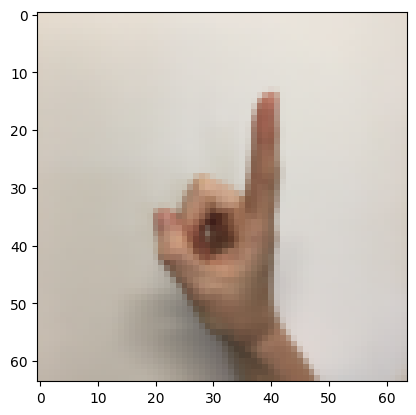

In [9]:
import matplotlib.pyplot as plt

plt.imshow(train_data[140,:,:,:])

#### 1080 photos of 64x64 size, 3 colors

### Transpose data into the format Torch wants - (n_channels, width, height)
https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

In [5]:
# https://numpy.org/doc/stable/reference/generated/numpy.transpose.html

train_data = np.transpose(train_data, axes=(0, 3, 1, 2))


train_data.shape

(1080, 3, 64, 64)

In [6]:
import torch

# Taken from Yann's paper
class LeNet5(torch.nn.Module):
    def __init__(self, input_height, input_width, n_classes):
        super().__init__()

        # C1. Put padding bcs MNIST had 32x32 data. We have 28x28
        self.C1 = torch.nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=2)

        # S2
        self.S2 = torch.nn.AvgPool2d(kernel_size=2)

        # C3
        self.C3 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)

        # S4
        self.S4 = torch.nn.AvgPool2d(kernel_size=4) # Edited this due to our data being 64x64

        # C5
        self.C5 = torch.nn.Conv2d(in_channels=16, out_channels=120, kernel_size=7) # Edited this due to our data being 64x64

        # F6
        self.F6 = torch.nn.Linear(in_features= 120, out_features=84)
        # self.layer4 = torch.nn.Conv2d(in_channels=64, out_channels=16, kernel_size=1)

        # F7
        self.F7 = torch.nn.Linear(in_features= 84, out_features=n_classes)

        
    
    def forward(self, x):
        
        ### forward pass module
        # x = torch.unsqueeze(x, 1)

        ### feed forward function
        # print("x.shape: ", x.shape)
        
        # PyTorch expects (Batch_size, channel_nr, width, height)
        
        l1out = self.C1(x)
        l1out = torch.nn.Tanh()(l1out)
        
        # print("l1out.shape: After C1 and TanH", l1out.shape)

        # AvgPooling
        l2out = self.S2(l1out)
        
        # print("l2out.shape: after AvgPooling ", l2out.shape)

        l3out = self.C3(l2out)
        l3out = torch.nn.Tanh()(l3out)
        
        # print("l3out.shape: After C3 and TanH", l3out.shape)

        # AvgPooling
        l4out = self.S4(l3out)
        
        # print("l4out.shape, After Avg Pooling: ", l4out.shape)

        l5out = self.C5(l4out)
        l5out = torch.nn.Tanh()(l5out)
        
        # print("l5out.shape: after C5 and Tanh: ", l5out.shape)

        l6out = self.F6(np.squeeze(l5out)) # squeeze bcs (120,1) vector to (120,) - a numpy broadcast thing
        
        # print("l6out.shape: after F6 and squeeze ", l6out.shape)
        
        l7out = self.F7(l6out)
        
        # print("l7out.shape: After F7 ", l7out.shape)

        return l7out

## Split Train into Train and Dev. Test set is in another HDF5 file

In [7]:
# Create Cross-Validation/Dev set
from sklearn.model_selection import train_test_split

X_train, X_dev, y_train, y_dev = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

In [8]:
print("X_train.shape: ", X_train.shape)
print("y_train.shape: ", y_train.shape)

X_train.shape:  (864, 3, 64, 64)
y_train.shape:  (864,)


In [9]:
MODE = "train"

In [10]:
# https://towardsdatascience.com/installing-pytorch-on-apple-m1-chip-with-gpu-acceleration-3351dc44d67c

# this ensures that the current MacOS version is at least 12.3+
print(torch.backends.mps.is_available())

# this ensures that the current current PyTorch installation was built with MPS activated.
print(torch.backends.mps.is_built())

True
True


In [11]:
# torch.device("mps") # Disable this if not on apple silicon!

In [12]:
import datetime
from utils.accuracies import dev_acc_and_loss, approx_train_acc_and_loss
import torch.nn.functional as F

# Modified From Ariel's EN.601.675 HW3
        
LOG_DIR = "."
MODEL_SAVE_DIR = "."
LEARNING_RATE = 0.0004 #arguments.get('lr')
BATCH_SIZE = 100 # 250 #arguments.get('bs')
EPOCHS = 2000 # arguments.get('epochs')
DATE_PREFIX = datetime.datetime.now().strftime('%Y%m%d%H%M')


TRAIN_IMAGES = X_train
TRAIN_LABELS = y_train
DEV_IMAGES = X_dev
DEV_LABELS = y_dev

### format dataset to the appropriate shape/dimensions necessary to be input into the model


n_train_imgs = TRAIN_IMAGES.shape[0]
HEIGHT = TRAIN_IMAGES.shape[1]
WIDTH = TRAIN_IMAGES.shape[2]
#  this will not be correct if not all classes are present in training
#   But if classes are entirely missing from training, we cannot possibly hope to do well on them
N_CLASSES = len(np.unique(TRAIN_LABELS))
# raise NotImplementedError

### Normalize 
train_imgs = (TRAIN_IMAGES - np.mean(TRAIN_IMAGES))/ np.std(TRAIN_IMAGES)
dev_imgs = (DEV_IMAGES - np.mean(DEV_IMAGES))/ np.std(DEV_IMAGES)

### change depending on your model's instantiation

model = LeNet5(input_height = HEIGHT, input_width= WIDTH,
                  n_classes=N_CLASSES)


### (OPTIONAL) : you can change the choice of optimizer here if you wish.
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)


for step in range(EPOCHS):
    i = np.random.choice(train_imgs.shape[0], size=BATCH_SIZE, replace=False)
    x = torch.from_numpy(np.squeeze(train_imgs[i]).astype(np.float32))
    y = torch.from_numpy(np.squeeze(TRAIN_LABELS[i].astype(int)))


    # Forward pass: Get logits for x
    logits = model(x)
    # Compute loss
    loss = F.cross_entropy(logits, y)
    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # log model performance every 100 epochs
    if step % 100 == 0:
        train_acc, train_loss = approx_train_acc_and_loss(model, train_imgs, TRAIN_LABELS)
        dev_acc, dev_loss = dev_acc_and_loss(model, dev_imgs, DEV_LABELS)
        step_metrics = {
            'step': step, 
            'train_loss': loss.item(), 
            'train_acc': train_acc,
            'dev_loss': dev_loss,
            'dev_acc': dev_acc
        }

        print(f"On step {step}:\tTrain loss {train_loss}\t|\tDev acc is {dev_acc}")
        # logger.writerow(step_metrics)
# LOGFILE.close()

# Save model
model_savepath = os.path.join(MODEL_SAVE_DIR,f"{DATE_PREFIX}_bestmodel.pt")


print("Training completed, saving model at {model_savepath}")
torch.save(model, model_savepath)

On step 0:	Train loss 1.7775444984436035	|	Dev acc is 0.17592592592592593
On step 100:	Train loss 0.6547996997833252	|	Dev acc is 0.7037037037037037
On step 200:	Train loss 0.4344528615474701	|	Dev acc is 0.7916666666666666
On step 300:	Train loss 0.19335252046585083	|	Dev acc is 0.8657407407407407
On step 400:	Train loss 0.05925237759947777	|	Dev acc is 0.8842592592592593
On step 500:	Train loss 0.02200922928750515	|	Dev acc is 0.9120370370370371
On step 600:	Train loss 0.018131954595446587	|	Dev acc is 0.9120370370370371
On step 700:	Train loss 0.008028620854020119	|	Dev acc is 0.9074074074074074
On step 800:	Train loss 0.008506075479090214	|	Dev acc is 0.9027777777777778
On step 900:	Train loss 0.004762554541230202	|	Dev acc is 0.9120370370370371
On step 1000:	Train loss 0.0034376252442598343	|	Dev acc is 0.9120370370370371
On step 1100:	Train loss 0.0028953636065125465	|	Dev acc is 0.9120370370370371
On step 1200:	Train loss 0.0022334272507578135	|	Dev acc is 0.9120370370370371
On 

## Let's see performance on test set

In [13]:
test_data = h5py.File("./datasets/Signs_Data_Testing.h5", "r")
TEST_IMAGES = test_data["test_set_x"]
test_labels = test_data["test_set_y"] # Do not train on these!!

In [14]:
# Transpose into correct shape for PyTorch

TEST_IMAGES = np.transpose(TEST_IMAGES, axes=(0, 3, 1, 2))

In [15]:
TEST_IMAGES.shape

(120, 3, 64, 64)

In [16]:
# model = torch.load(WEIGHTS_FILE) # Load model parameters from file to avoid retraining

predictions = []
# testSetMean = TEST_IMAGES.mean() # Can't do that - only remove training parameters from it
# testSetStd = TEST_IMAGES.std()
for test_case in TEST_IMAGES:

    ### normalization schemes
    test_case = (test_case - np.mean(TRAIN_IMAGES)) / np.std(TRAIN_IMAGES)

    # test_case = test_case.reshape(1,28,28)


    x = torch.from_numpy(test_case.astype(np.float32))
    # x = x.view(1,-1)
    logits = model(x)
    logits = logits.reshape(-1, 6)
    pred = torch.max(logits, 1)[1]
    predictions.append(pred.item())

predictions[:15] # First 15 predicted labels

[0, 0, 0, 5, 1, 0, 4, 1, 5, 1, 5, 1, 3, 1, 1]

In [17]:
from utils.accuracies import accuracy

print("Test accuracy: ", accuracy(np.array(predictions), np.array(test_labels)))

Test accuracy:  0.9083333333333333
